In [1]:
# sets up matplotlib with interactive features

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

основная цель: изучить зависимость стоимости различных аппартаментов в различных штатах


первостепенно загружаем наши данные в датафрейм, очищаем из от ненужных столбцов, а также максимальных выбросов. Удаление значений, грубо нарушающие логику данных серьезно влияют на репрезентативность данных и искажают значения.

In [2]:
housing = pd.read_csv('housing.csv')

In [3]:

del housing['url']
del housing['region_url']
del housing['image_url']
del housing['description']
del housing['lat']
del housing['long']
del housing['id']
housing['parking_options'] = housing['parking_options'].fillna('no parking')
housing['laundry_options'] = housing['laundry_options'].fillna('None')
q_hi_p  = housing["price"].quantile(0.99)
q_hi_sq  = housing["sqfeet"].quantile(0.99)
q_hi_beds  = housing["beds"].quantile(0.999)
q_hi_baths  = housing["baths"].quantile(0.999)
housing = housing[housing['price']<q_hi_p]
housing = housing[housing['sqfeet']<q_hi_sq]
housing = housing[housing['beds']<q_hi_beds]
housing = housing[housing['baths']<q_hi_beds]

проведем беглый осмотр полученных данных

In [3]:
housing.head()

region  price       type  sqfeet  beds  baths  cats_allowed  \
0  reno / tahoe   1148  apartment    1078     3    2.0             1   
1  reno / tahoe   1200      condo    1001     2    2.0             0   
2  reno / tahoe   1813  apartment    1683     2    2.0             1   
3  reno / tahoe   1095  apartment     708     1    1.0             1   
4  reno / tahoe    289  apartment     250     0    1.0             1   

   dogs_allowed  smoking_allowed  wheelchair_access  electric_vehicle_charge  \
0             1                0                  0                        0   
1             0                0                  0                        0   
2             1                1                  0                        0   
3             1                1                  0                        0   
4             1                1                  1                        0   

   comes_furnished  laundry_options  parking_options state  
0                0      w/d in unit          carport    ca  
1                0      w/d hookups          carport    ca  
2                0      w/d in unit  attached garage    ca  
3                0      w/d in unit          carport    ca  
4                1  laundry on site       no parking    ca

In [127]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376394 entries, 0 to 384976
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   376394 non-null  object 
 1   price                    376394 non-null  int64  
 2   type                     376394 non-null  object 
 3   sqfeet                   376394 non-null  int64  
 4   beds                     376394 non-null  int64  
 5   baths                    376394 non-null  float64
 6   cats_allowed             376394 non-null  int64  
 7   dogs_allowed             376394 non-null  int64  
 8   smoking_allowed          376394 non-null  int64  
 9   wheelchair_access        376394 non-null  int64  
 10  electric_vehicle_charge  376394 non-null  int64  
 11  comes_furnished          376394 non-null  int64  
 12  laundry_options          376394 non-null  object 
 13  parking_options          376394 non-null  object 
 14  stat

построим гистограмму, показывающую распределение съемных домов (квартир) по штатам

In [73]:
plt.figure(figsize = (12,7))
sns.histplot(housing.state)
plt.xticks(rotation = 90)
plt.show()

в нашем случае выделяются три штата: ca, fl, tx. наименьшие значения: me, vt, wy. 


Определим основные зависимости значений

In [7]:
housing.corr()

price    sqfeet      beds     baths  cats_allowed  \
price                    1.000000  0.320045  0.165081  0.240863     -0.009026   
sqfeet                   0.320045  1.000000  0.755854  0.639770     -0.062082   
beds                     0.165081  0.755854  1.000000  0.627078     -0.063623   
baths                    0.240863  0.639770  0.627078  1.000000     -0.000463   
cats_allowed            -0.009026 -0.062082 -0.063623 -0.000463      1.000000   
dogs_allowed            -0.007845 -0.024187 -0.030198  0.034859      0.888746   
smoking_allowed         -0.155423 -0.026062  0.001390 -0.006785      0.013016   
wheelchair_access        0.070395 -0.021627 -0.040784  0.021302      0.120227   
electric_vehicle_charge  0.115680  0.001050 -0.020826  0.003036      0.047061   
comes_furnished         -0.009583 -0.018586 -0.002142  0.026311     -0.053959   

                         dogs_allowed  smoking_allowed  wheelchair_access  \
price                       -0.007845        -0.155423           0.070395   
sqfeet                      -0.024187        -0.026062          -0.021627   
beds                        -0.030198         0.001390          -0.040784   
baths                        0.034859        -0.006785           0.021302   
cats_allowed                 0.888746         0.013016           0.120227   
dogs_allowed                 1.000000         0.011020           0.127021   
smoking_allowed              0.011020         1.000000          -0.222952   
wheelchair_access            0.127021        -0.222952           1.000000   
electric_vehicle_charge      0.046947        -0.088372           0.182340   
comes_furnished             -0.034111        -0.159529           0.199813   

                         electric_vehicle_charge  comes_furnished  
price                                   0.115680        -0.009583  
sqfeet                                  0.001050        -0.018586  
beds                                   -0.020826        -0.002142  
baths                                   0.003036         0.026311  
cats_allowed                            0.047061        -0.053959  
dogs_allowed                            0.046947        -0.034111  
smoking_allowed                        -0.088372        -0.159529  
wheelchair_access                       0.182340         0.199813  
electric_vehicle_charge                 1.000000         0.069931  
comes_furnished                         0.069931         1.000000

Для более наглядной работы построим тепловую карту значений.

In [8]:
plt.figure(figsize=(10,10))
# heat matrix that shows correlation across all numerical variables
sns.heatmap(data=housing.corr(),annot=True)
plt.tight_layout()
plt.show()

Анализируя полученные даны можно сделать вывод, что наибольший положительный эффект на значение цены влияют значения площади (sqfeet) - 0.32, количество жилых комнат (beds) - 0.17, количество ванных комнат (baths) - 0.24. Наибольший негативный эффект вызывает разрешение на курение (smoking_allowed) - -0.16. 

In [4]:
plt.hist(housing.price)

(array([  3737.,  41717., 139371.,  94443.,  52031.,  23503.,  10342.,
          6214.,   3520.,   1516.]),
 array([   0. ,  339.4,  678.8, 1018.2, 1357.6, 1697. , 2036.4, 2375.8,
        2715.2, 3054.6, 3394. ]),
 <BarContainer object of 10 artists>)

In [6]:
mean_price = housing.price.mean()
mean_price

1143.5394719363221

In [7]:
median_price = housing.price.median()
median_price

1025.0

Так как наибольшая положительная корреляция у цены наблюдается со значением площади, стоит рассмотреть данный вопрос более подробно. Лучшим выбором для визуализации данного отношения будет являся гексагональный график. Выбор пал на данный график по тем сообращениям, что стандартный граффик рассеяния будет слишком насыщен точками и не даст полной картины.

In [10]:
sns.jointplot(data = housing, x = 'sqfeet', y = 'price', kind ="hex")

Сравним цены на жилье в зависимости от количества жилых помещений. Так как в данном вопросе имеется отрицательная корреляция в зависимости от разрешения на курение, то стоит обратиться к распределению значений по данному критерию

<AxesSubplot:xlabel='beds', ylabel='price'>

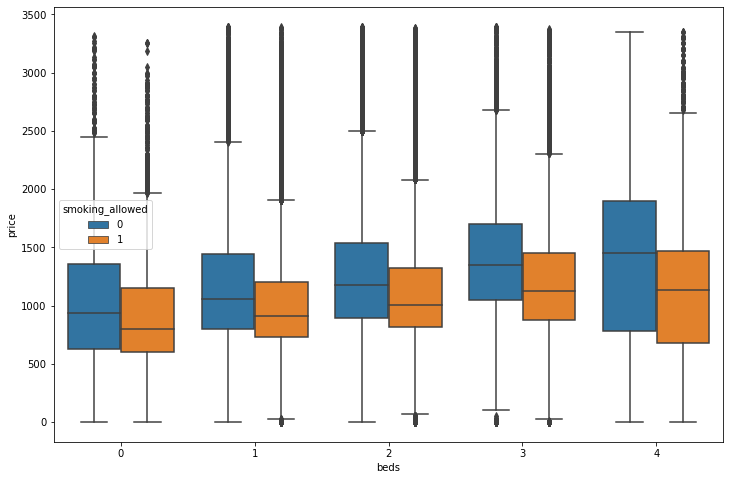

In [115]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'beds', y = 'price', data = housing, hue = 'smoking_allowed')

Из графика видно, что средние цены на жилье с разрешением на курение стоят дешевле, чем жилье без разрешения на курение. Также цена варьируется в зависимости от количества комнат.
Заметна тенденция на повышение стоимости в зависимости от количества жилых комнат. 
Стоит заметить большое количество выбросов, а также большой интерквартильный размах, что влечет за собой слошность оценки общей картины.
Для уточнения данных построим график-виолончель

<AxesSubplot:xlabel='beds', ylabel='price'>

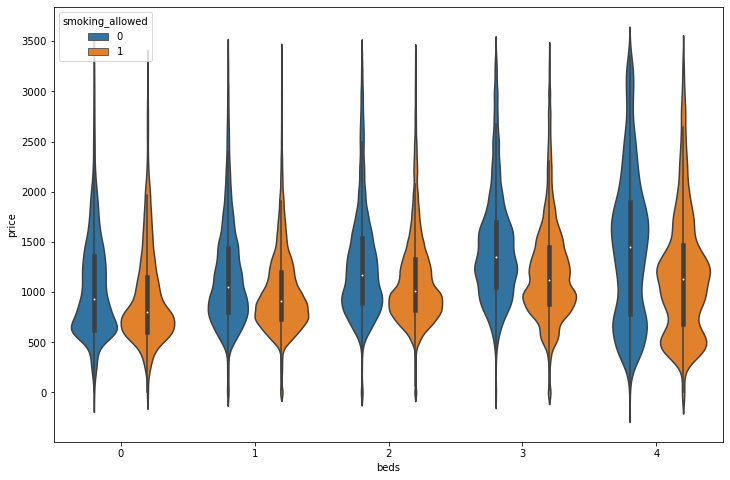

In [123]:
plt.figure(figsize = (12,8))
sns.violinplot(x = 'beds', y = 'price', data = housing, hue = 'smoking_allowed')

Из значений графиков-виолончелий наглядно видно распределение цен. Из данного графика можно определить, что цены жилых помещений с запретом на курение распределены более равномерно, нежели значения жилых помещений с разрешением на курение, а также, что они имеют большую тенденцию на повышение цены, в отличие от цен на жилые помещения с разрешением на курение, где имеются ярковыраженные пики.

Проведем подобный анализ для цены в зависимости от количества ванных комнат.

<AxesSubplot:xlabel='baths', ylabel='price'>

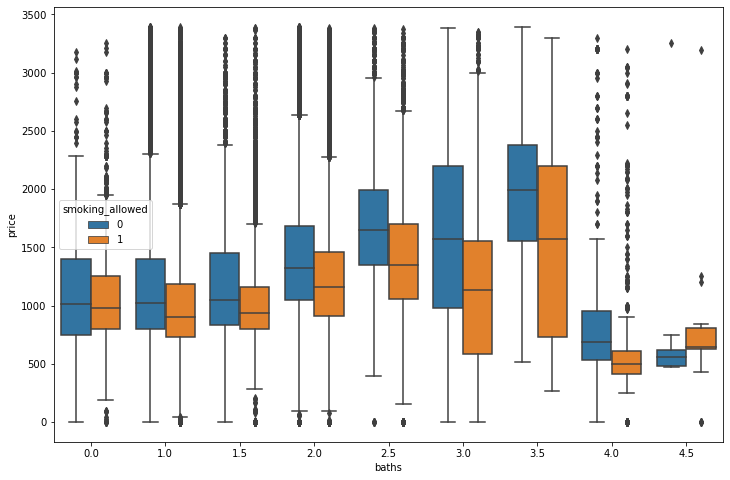

In [124]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'baths', y = 'price', data = housing, hue = 'smoking_allowed')

In [125]:
plt.figure(figsize = (12,8))
sns.violinplot(x = 'baths', y = 'price', data = housing, hue = 'smoking_allowed')

<AxesSubplot:xlabel='baths', ylabel='price'>

На основании графиков можно утверждать, что тенденция, заданная графиком сравнения цены в зависимости от количества комнат сдесь сохраняется. В том числе и распределение цен в зависимости от разрешения курения. Однако, стоит отметить значения при количестве ванных равных 4.5. В данном случае средняя цена и пик жилых помещений с запретом на курение ниже, чем среднее значение и пик жилых помещений с разрешением на курение. Это может быть связано со спецификой применения подобных помещений, но, так как количество значений с данными показателями мало относительно остальных распределений, а также имеются серьезные выбросы, то, вполне возможно данных недостаточно, чтобы провести точный анализ.

Стоит уточнить корреляции в зависимости от значений дял каждого штата. Для удобной работы стоит использовать метод sns.FacetGrid, который позволит нам построить графики распределения сразу же для всех штатов, что позволит нам сравнить их друг с другом. 
Первым построим отношение значений цены от площади.

In [76]:
sq_scat = sns.FacetGrid(housing, col="state",  height=3.5, col_wrap=6, margin_titles = True, row_order = True)
sq_scat.map_dataframe(sns.regplot, x="sqfeet", y = 'price', data = housing, line_kws={"color": "red"})

plt.show()

Из графиков видно, что во всех штатах наблюдается положительная корреляция цены от площади жилого помещения. Наиболее выраженная корреляция у штата hi, наименее выраженная корреляция у штатов: ms, pa.

Построим график отношения цены от количества комнат.

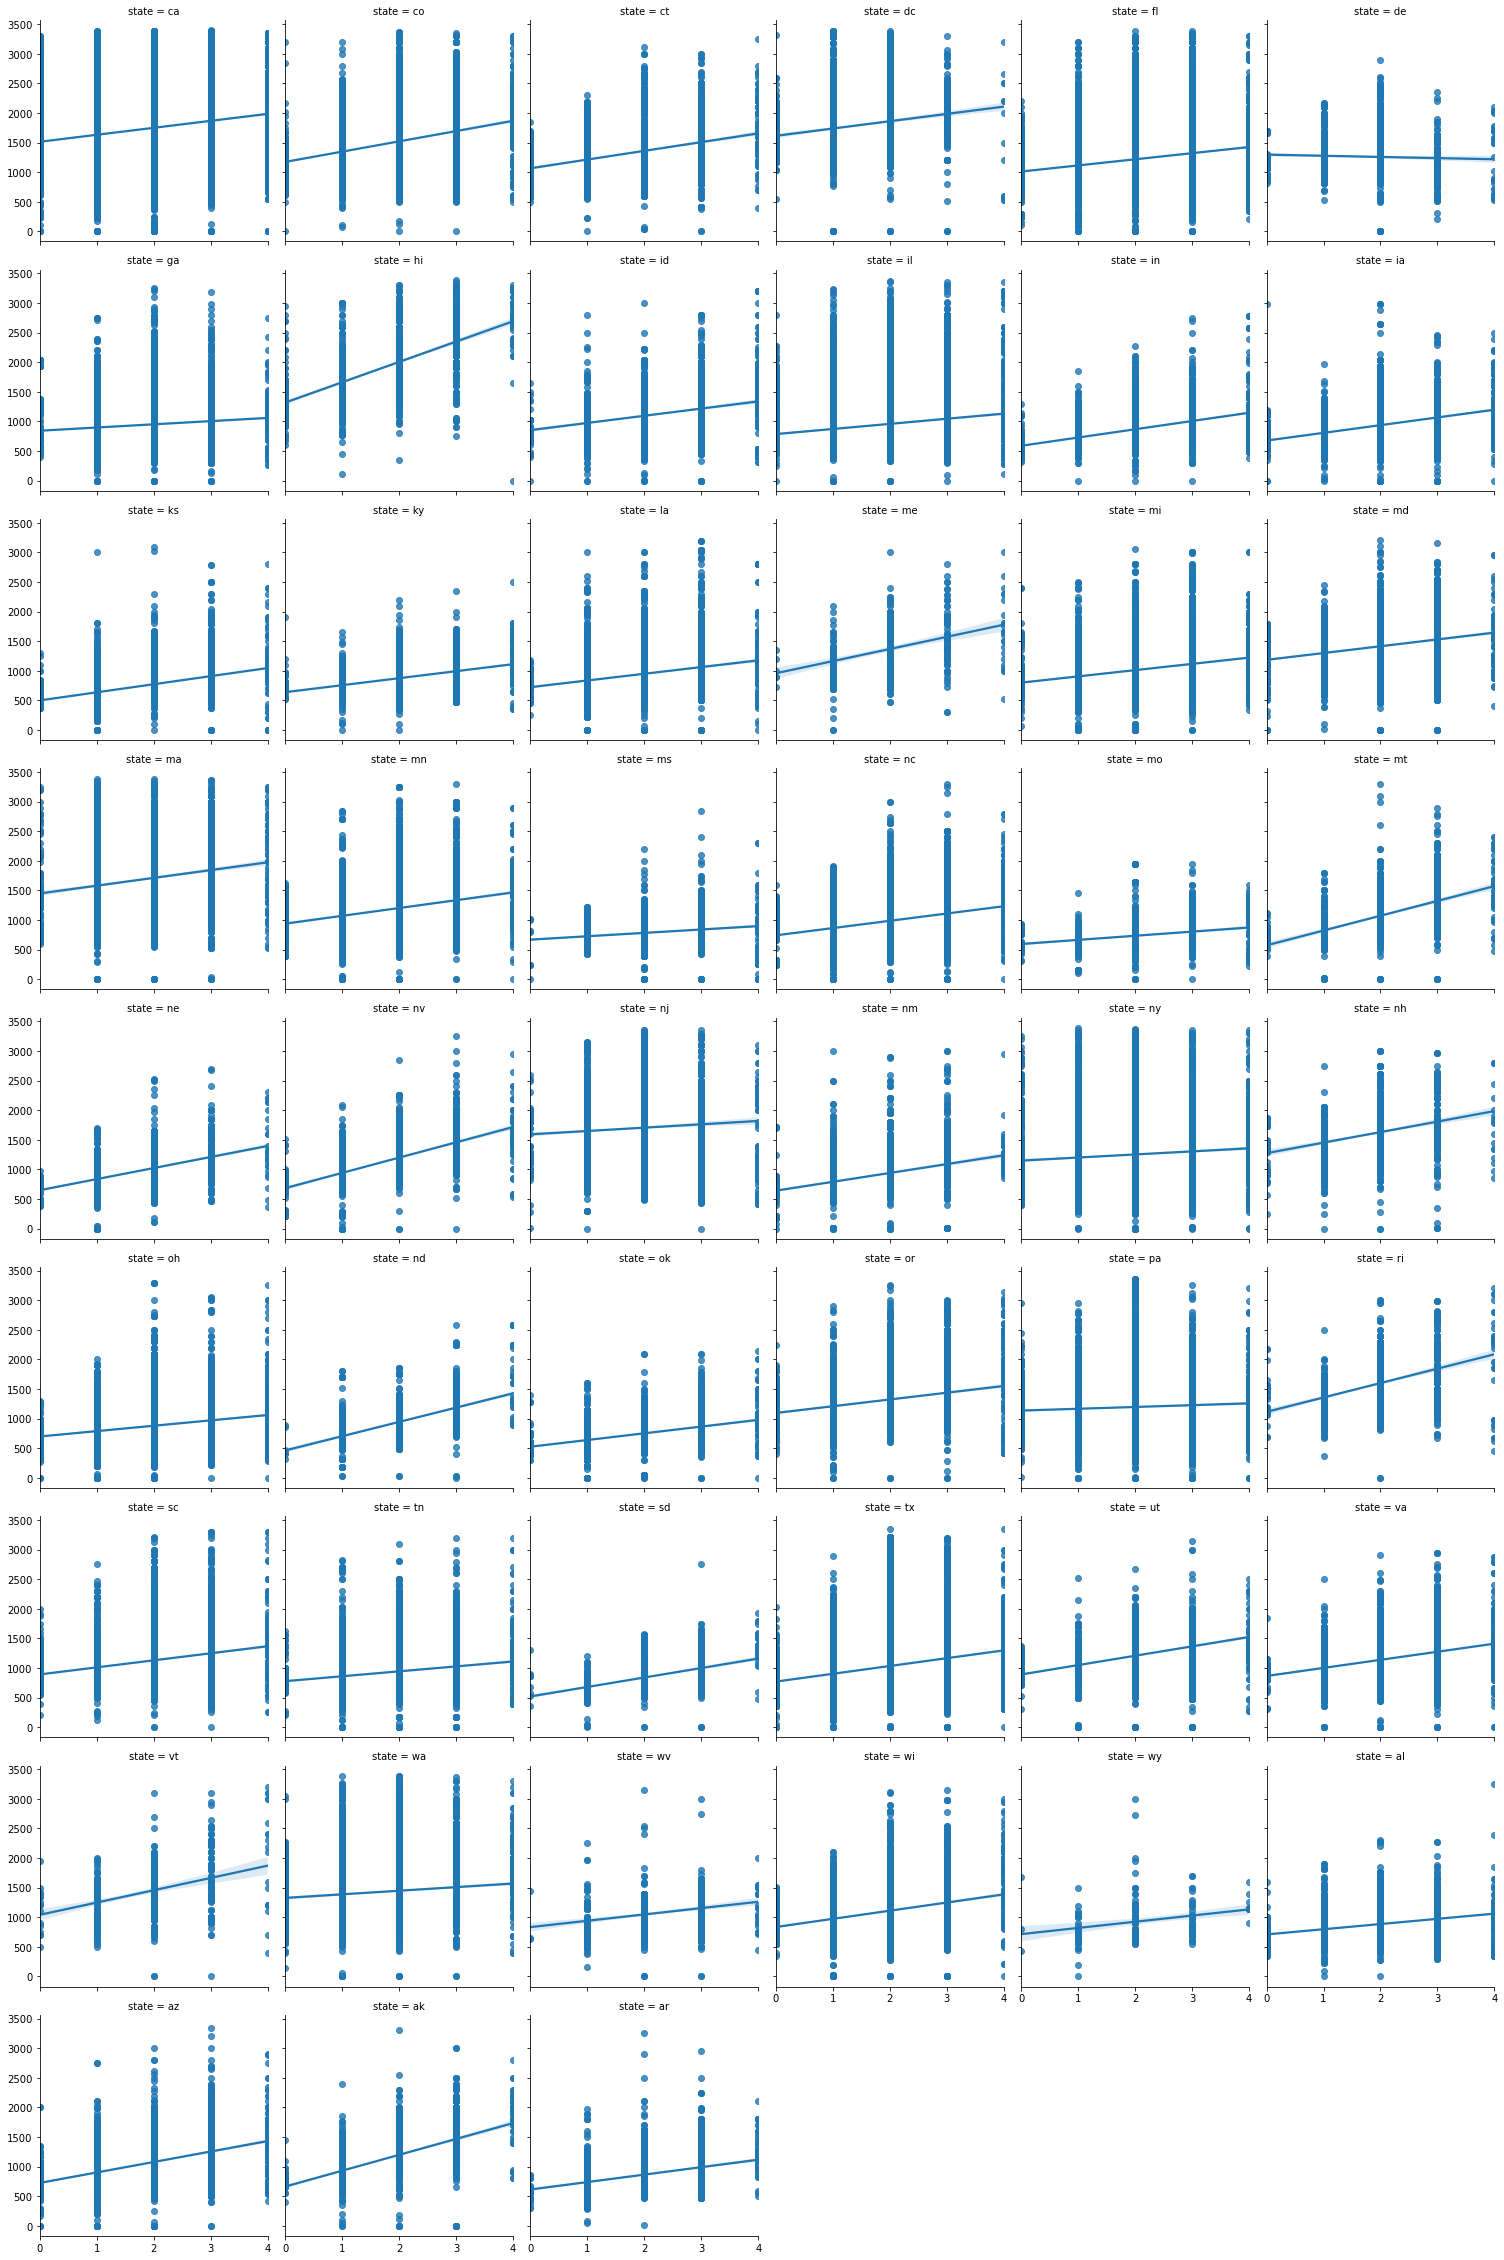

In [77]:
beds_scat = sns.FacetGrid(housing, col="state",  height=3.5, col_wrap=6, margin_titles = True, row_order = True)
beds_scat.map_dataframe(sns.regplot, x="beds", y = 'price', data = housing)

plt.show()

На данных графиках  корреляция цены от количества комнат во всех штатах является положительной. Наибольшая корреляция наблюдается в штате hi.

Для уточнения данных можно построить коробчатые диаграммы, которые дадут представления о распределении цен в зависимости от штата и количества комнат.

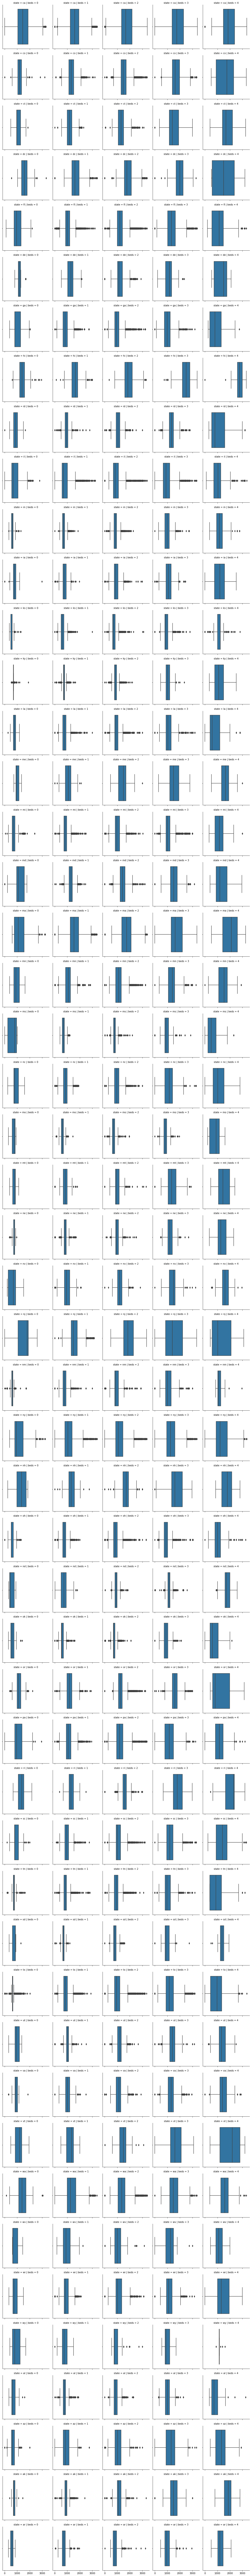

In [112]:
beds_scat = sns.FacetGrid(housing, row="state", col = 'beds')
beds_scat.map_dataframe(sns.boxplot, x = 'price', data = housing)

plt.show()

Из данного графика можно сделать вывод, что в зависимости от штата цена на жилое помещение в зависимости от количества комнат изменяется.

Взглянем на зависимость цены от наличия парковочных мест

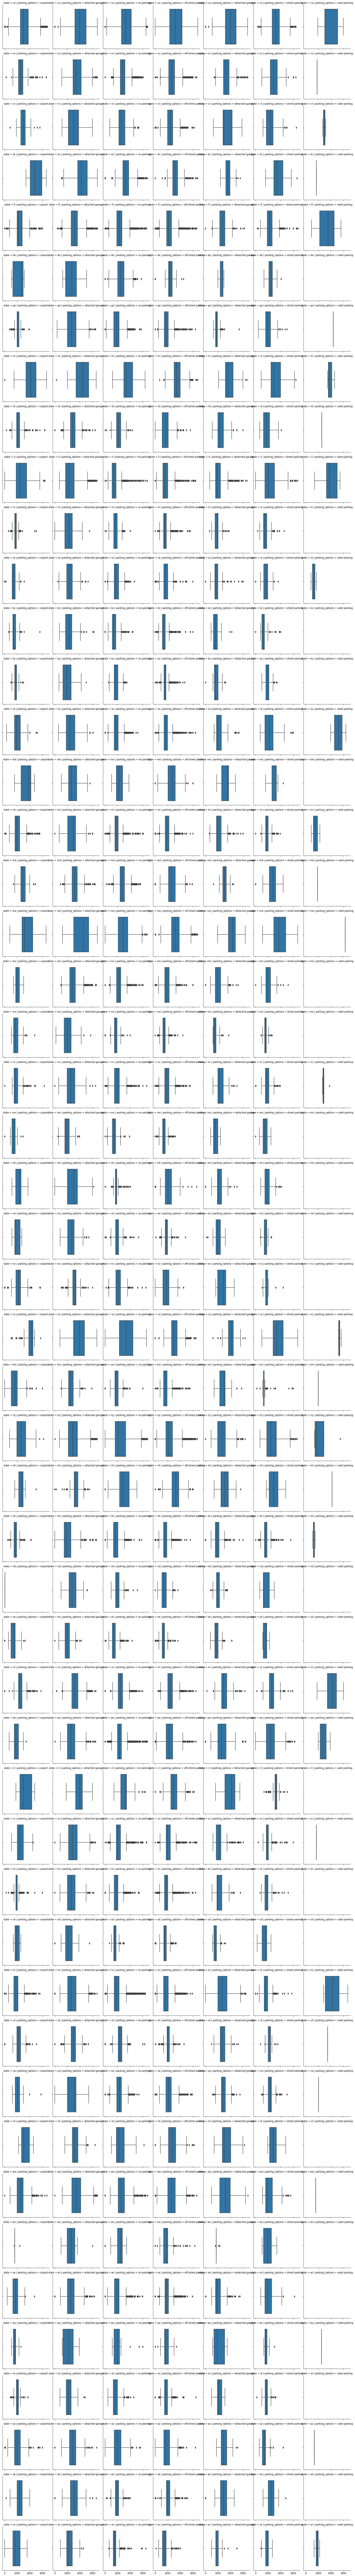

In [78]:
beds_scat = sns.FacetGrid(housing, row="state", col = 'parking_options')
beds_scat.map_dataframe(sns.boxplot, x = 'price', data = housing)

plt.show()

Сравнивая графики цены без наличия парковочного места и с наличием парковочно места любого типа заметно повышение цены. Отсюда можно сделать вывод, что наличие парковки положительно влияет на цену.

Определим зависимость цены от наличия ванных комнат

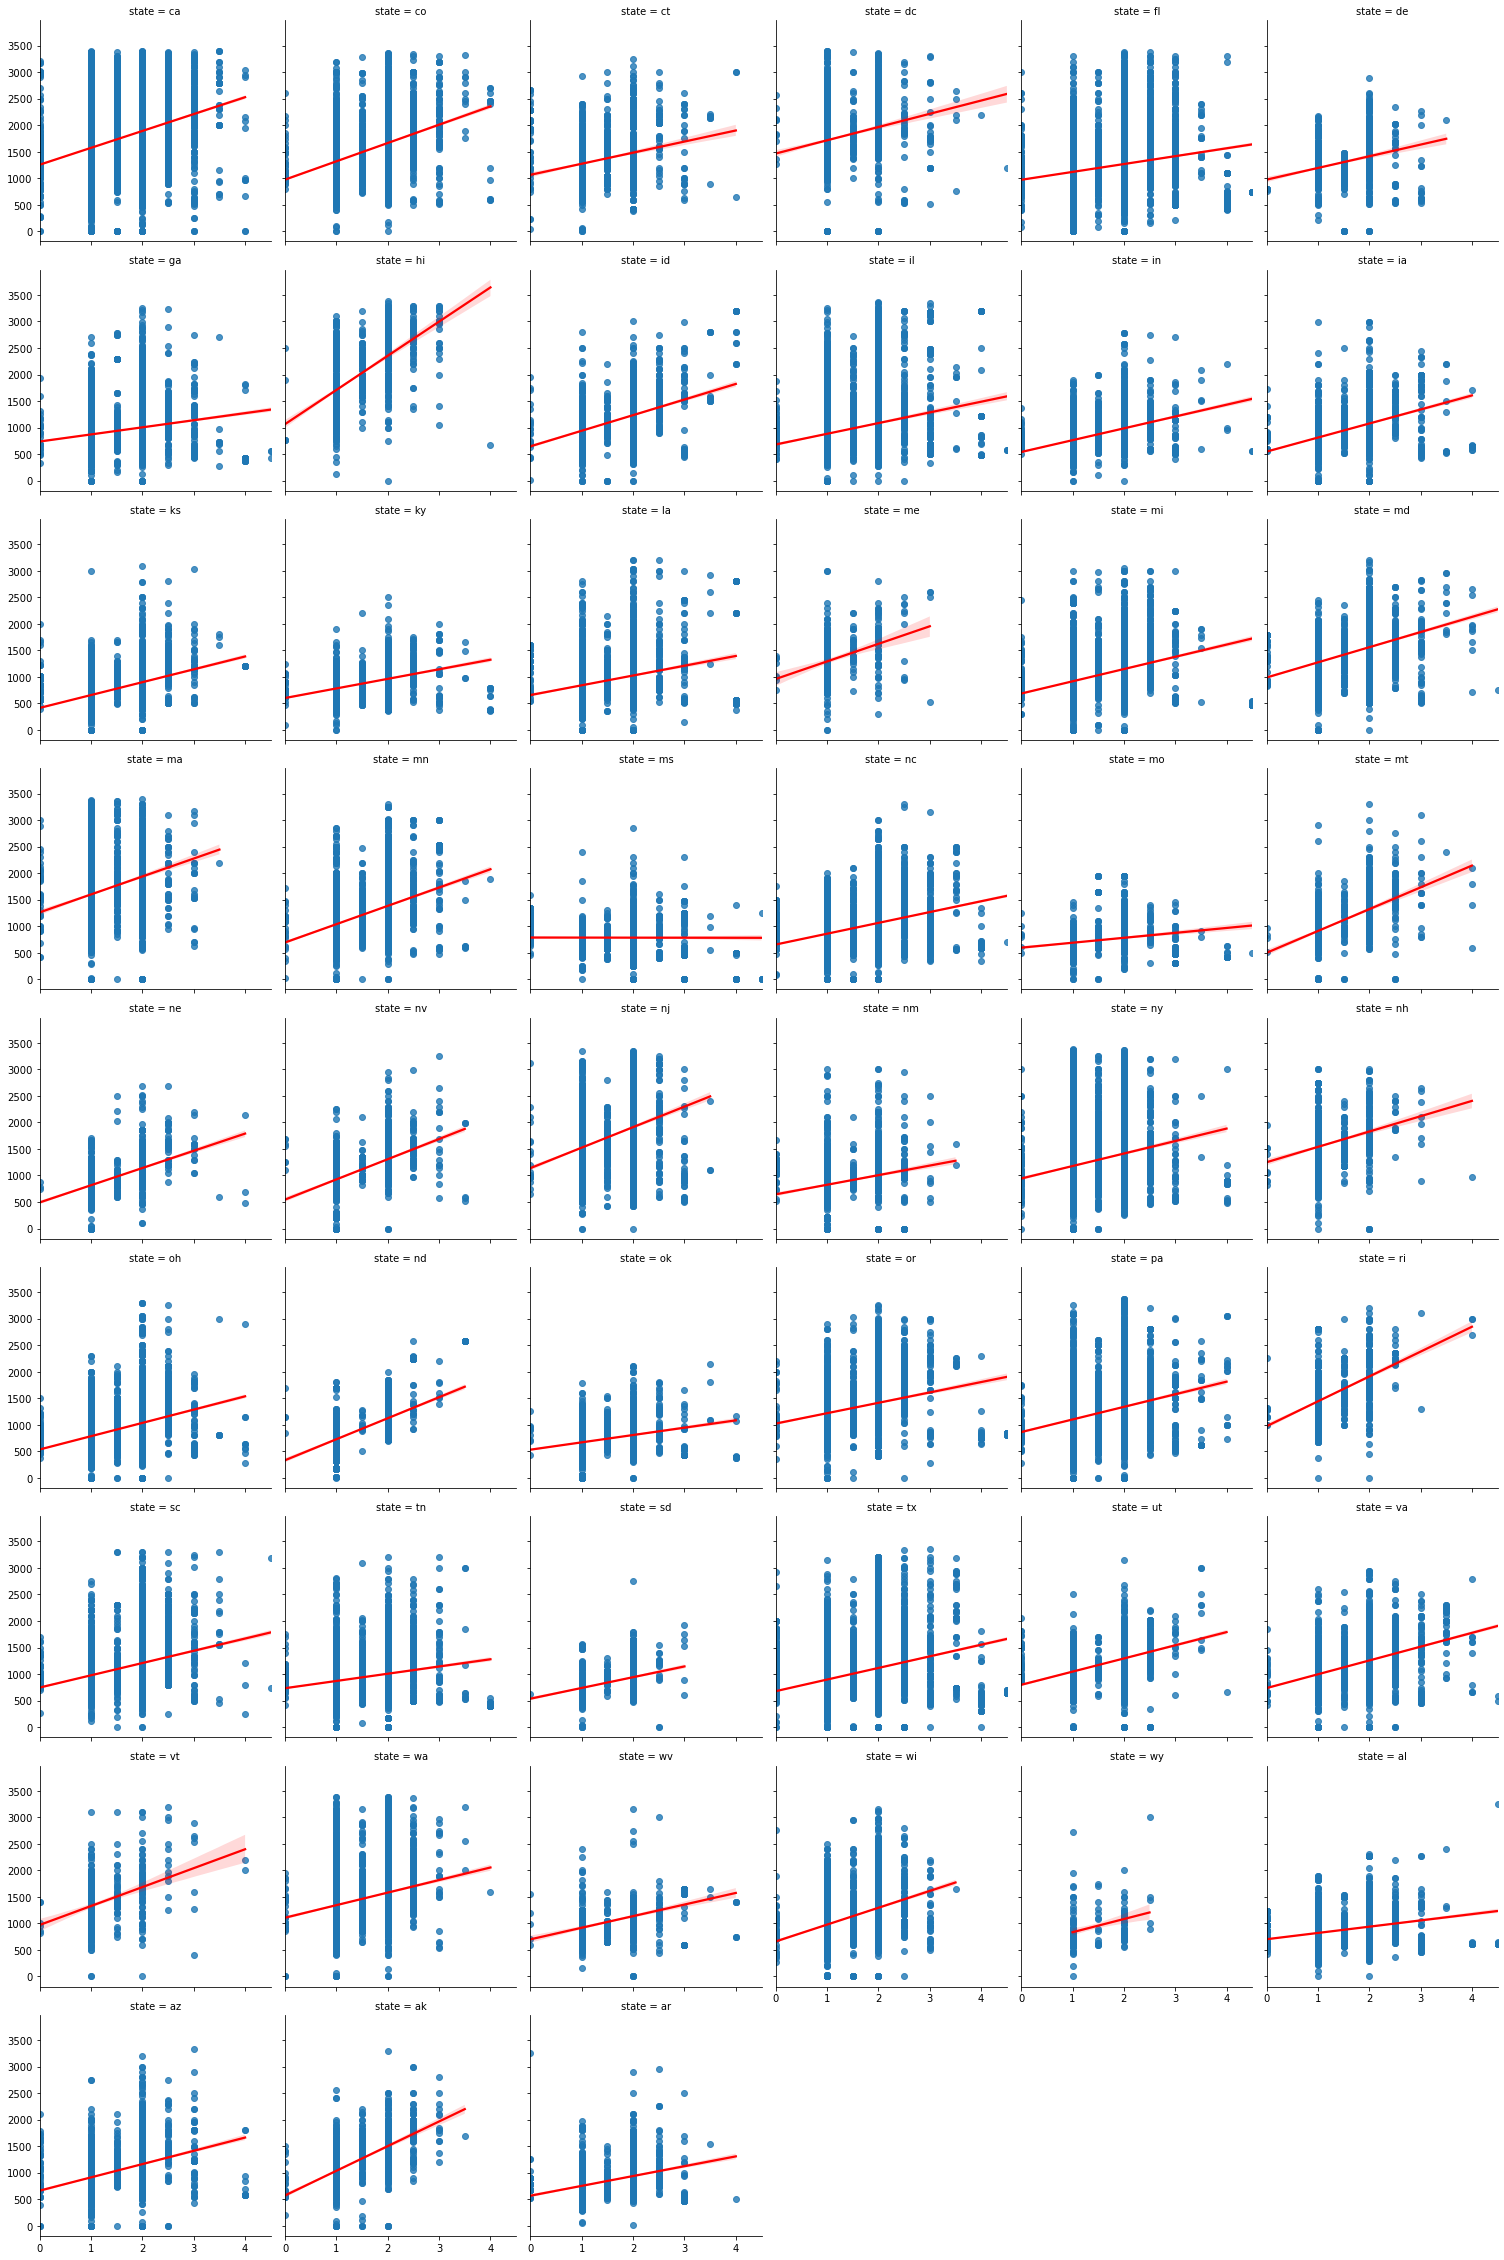

In [79]:
baths_scat = sns.FacetGrid(housing, col="state",   height=3.5, col_wrap=6, margin_titles = True, row_order = True)
baths_scat.map_dataframe(sns.regplot, x = 'baths',y = 'price', data = housing, line_kws={"color": "red"})
plt.show()

Общая тенденция осталось положительной, однако в штате ms заметна отрицательная корреляция, что выбивается из общей картины данных.

Для определения значений первого, второго, третьего квартиля, а также анализа количества и значений выбросов построим коробчатые диаграммы.

In [ ]:
beds_scat = sns.FacetGrid(housing,row="state", col = 'baths')
beds_scat.map_dataframe(sns.boxplot, x = 'price', data = housing)

plt.show()

Рассмотрим вопрос влияния наличия зарядки для электрокаров на цену 

In [80]:
el_charges_scat = sns.FacetGrid(housing, col="state",   height=3.5, col_wrap=6, margin_titles = True, row_order = True)
el_charges_scat.map_dataframe(sns.regplot, x = 'electric_vehicle_charge',y = 'price', data = housing, line_kws={"color": "red"})
plt.show()

Стоит отметить, что влияние на цену разнится. Так

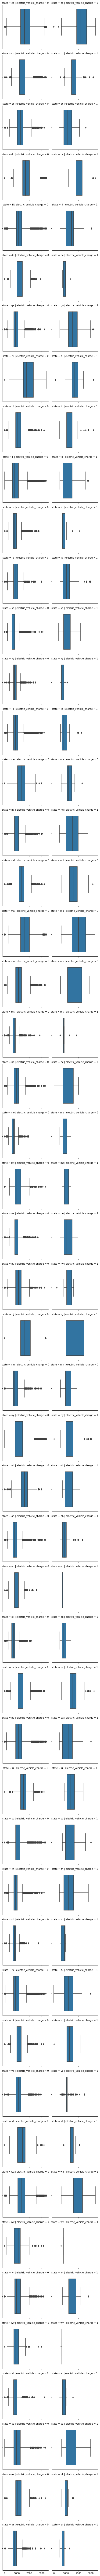

In [110]:
beds_scat = sns.FacetGrid(housing, row="state", col = 'electric_vehicle_charge')
beds_scat.map_dataframe(sns.boxplot, x = 'price', data = housing)

plt.show()

In [81]:
smoking_allowed_scat = sns.FacetGrid(housing, col="state",   height=3.5, col_wrap=6, margin_titles = True, row_order = True)
smoking_allowed_scat.map_dataframe(sns.regplot, x = 'smoking_allowed',y = 'price', data = housing, line_kws={"color": "red"})
plt.show()

In [109]:
beds_scat = sns.FacetGrid(housing, row="state", col = 'smoking_allowed')
beds_scat.map_dataframe(sns.boxplot, x = 'price', data = housing)

plt.show()